In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
import xgboost
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import seaborn as sns
import operator 
plt.style.use('ggplot')
%matplotlib inline 

Import the data (make sure you update this on a daily basis)

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/05-16-2020.csv')
us_medical_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/05-16-2020.csv')

In [3]:
latest_data.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-05-17 02:32:32,34.223334,-82.461707,34,0,0,34,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-05-17 02:32:32,30.295065,-92.414197,192,11,0,181,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-05-17 02:32:32,37.767072,-75.632346,668,9,0,659,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-05-17 02:32:32,43.452658,-116.241552,773,22,0,751,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-05-17 02:32:32,41.330756,-94.471059,4,0,0,4,"Adair, Iowa, US"


In [4]:
latest_data.to_csv('us.csv')

In [5]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,856,868,872,876,880,898,916,933,946,948
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,754,755,755,758,760,761,761,761,761,761
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,43,45,45,45,45,48,48,48,48,50


In [6]:
us_medical_data.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-05-17 02:32:37,32.3182,-86.9023,11674,485,NaN,11189.0,1,238.090139,153494.0,1387.0,4.154531,84000001,USA,3130.495790,11.881103
1,Alaska,US,2020-05-17 02:32:37,61.3707,-152.4044,388,10,344.0,34.0,2,53.038432,33281.0,NaN,2.577320,84000002,USA,4549.412545,NaN
2,American Samoa,US,2020-05-17 02:32:37,-14.2710,-170.1320,0,0,NaN,0.0,60,0.000000,105.0,NaN,NaN,16,ASM,188.709764,NaN
3,Arizona,US,2020-05-17 02:32:37,33.7298,-111.4312,13666,679,3357.0,9630.0,4,187.752869,146788.0,1683.0,4.968535,84000004,USA,2016.674092,12.315235
4,Arkansas,US,2020-05-17 02:32:37,34.9697,-92.3731,4578,98,3472.0,1008.0,5,151.699713,81644.0,520.0,2.140673,84000005,USA,2705.410954,11.358672


In [7]:
cols = confirmed_df.keys()


### Get outbreak numbers for each day since 1/22/20

In [8]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [9]:
confirmed.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20
0,0,0,0,0,0,0,0,0,0,0,...,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072
1,0,0,0,0,0,0,0,0,0,0,...,856,868,872,876,880,898,916,933,946,948
2,0,0,0,0,0,0,0,0,0,0,...,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201
3,0,0,0,0,0,0,0,0,0,0,...,754,755,755,758,760,761,761,761,761,761
4,0,0,0,0,0,0,0,0,0,0,...,43,45,45,45,45,48,48,48,48,50


Getting daily increases

In [10]:
countries=['china','italy','us','spain','france','germany','uk','russia','brazil']
g = globals()
def init_lists(string):
    ''' initialize the name of lists for each country for 
    confirmed, death, and recovery cases'''
    
    
    for i in countries:
        g['{0}_{1}'.format(i,string)] = []

In [11]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 

#Initializing all the lists
init_lists('cases')
init_lists('deaths')
init_lists('recoveries')

values=['China','Italy','US','Spain','France','Germany','United Kingdom','Russia','Brazil']

for i in dates:
    confirmed_sum = confirmed[i].sum()
    print(type(confirmed_sum))
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculating the mortality and recovery rate
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # getting the confirmed, deaths, and recovered, for each country
    for j in range(len(countries)):
        g['{0}_{1}'.format(countries[j],'cases')].append(confirmed_df[confirmed_df['Country/Region']==values[j]][i].sum())
        g['{0}_{1}'.format(countries[j],'deaths')].append(deaths_df[deaths_df['Country/Region']==values[j]][i].sum())
        g['{0}_{1}'.format(countries[j],'recoveries')].append(recoveries_df[recoveries_df['Country/Region']==values[j]][i].sum())

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'nu

In [12]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

# confirmed cases
world_daily_increase = daily_increase(world_cases)

# deaths
world_daily_death = daily_increase(total_deaths)


# recoveries
world_daily_recovery = daily_increase(total_recovered)


In [19]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
#world_cases = np.array(world_cases).reshape(-1, 1)
#total_deaths = np.array(total_deaths).reshape(-1, 1)
#total_recovered = np.array(total_recovered).reshape(-1, 1)

In [20]:
days_since_1_22

array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 31],
       [ 32],
       [ 33],
       [ 34],
       [ 35],
       [ 36],
       [ 37],
       [ 38],
       [ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 51],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 63],
       [ 64],
       [ 65],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
      

In [25]:
ls=[world_cases, total_deaths, total_recovered, total_active]
df=pd.DataFrame(ls)
df=df.T
df.columns=['confirmed','death','recovered','active']
df

,confirmed,death,recovered,active
0,555,17,28,510
1,654,18,30,606
2,941,26,36,879
3,1434,42,39,1353
4,2118,56,52,2010
...,...,...,...,...
113,4442163,302418,1587893,2551852
114,4542347,307666,1637067,2597614
115,4634068,311781,1693197,2629090
116,4713620,315185,1733963,2664472


In [26]:
df=np.log(df)
df.head()

,confirmed,death,recovered,active
0,6.318968,2.833213,3.332205,6.234411
1,6.483107,2.890372,3.401197,6.406880
2,6.846943,3.258097,3.583519,6.778785
3,7.268223,3.737670,3.663562,7.210080
4,7.658228,4.025352,3.951244,7.605890


In [27]:
df=df.shift(periods=1, freq=None, axis=0)
df=df.fillna(0)

df['days']=days_since_1_22
df['label']=np.log(total_active)
df.head()

,confirmed,death,recovered,active,days,label
0,0.000000,0.000000,0.000000,0.000000,0,6.234411
1,6.318968,2.833213,3.332205,6.234411,1,6.406880
2,6.483107,2.890372,3.401197,6.406880,2,6.778785
3,6.846943,3.258097,3.583519,6.778785,3,7.210080
4,7.268223,3.737670,3.663562,7.210080,4,7.605890


In [28]:
X_train_confirmed, X_test_confirmed = train_test_split(df, test_size=0.20, shuffle=False) 
X_train_confirmed.head()


,confirmed,death,recovered,active,days,label
0,0.000000,0.000000,0.000000,0.000000,0,6.234411
1,6.318968,2.833213,3.332205,6.234411,1,6.406880
2,6.483107,2.890372,3.401197,6.406880,2,6.778785
3,6.846943,3.258097,3.583519,6.778785,3,7.210080
4,7.268223,3.737670,3.663562,7.210080,4,7.605890


In [20]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
data_normalized_train = scalar.fit_transform(X_train_confirmed.iloc[:, :-1])
data_normalized_test=scalar.transform(X_test_confirmed.iloc[:, :-1])
train=np.concatenate((X_train_confirmed.iloc[:, -1 :], data_normalized_train), axis = 1)
test=np.concatenate((X_test_confirmed.iloc[:, -1:], data_normalized_test), axis = 1)


In [32]:

X_train=X_train_confirmed.iloc[:, :-1]
X_test=X_test_confirmed.iloc[:, :-1]
y_train=X_train_confirmed.iloc[:, -1:]
y_test=X_test_confirmed.iloc[:, -1:]


Model for predicting # of confirmed cases. I am using support vector machine, bayesian ridge , and linear regression in this example. 

In [33]:
X_train

,confirmed,death,recovered,active,days
0,0.000000,0.000000,0.000000,0.000000,0
1,6.318968,2.833213,3.332205,6.234411,1
2,6.483107,2.890372,3.401197,6.406880,2
3,6.846943,3.258097,3.583519,6.778785,3
4,7.268223,3.737670,3.663562,7.210080,4
...,...,...,...,...,...
89,14.691307,12.030361,13.342794,14.291563,89
90,14.720428,12.061607,13.377483,14.318297,90
91,14.751230,12.102022,13.429708,14.339591,91
92,14.780442,12.138393,13.473085,14.362273,92


In [34]:
# # use this to find the optimal parameters for SVR for polynomial kernal
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
degree = [2,3]
svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'degree': degree}

svm = SVR(kernel='poly')
svm_poly = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_iter=30, verbose=1)
svm_poly.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A

/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='poly',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=30, n_jobs=None,
                   param_distributions={'C': [0.01, 0.1, 1], 'degree': [2, 3],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [35]:
df.columns

Index(['confirmed', 'death', 'recovered', 'active', 'days', 'label'], dtype='object')

In [36]:
df = pd.DataFrame(svm_poly.cv_results_)
df=df[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_gamma', 'param_epsilon', 'param_degree', 'param_C', 'params',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'mean_train_score', 'std_train_score']]
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
df=df.sort_values(by=['mean_test_score'])
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_epsilon,param_degree,param_C,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
27,0.013307,0.004751,0.001415,0.000057,0.01,0.1,2,1,"{'gamma': 0.01, 'epsilon': 0.1, 'degree': 2, '...",2.315583e-01,1.940524e-01,1,2.062048e-02,1.048728e-02
5,0.011759,0.003566,0.001316,0.000044,0.1,0.1,2,0.01,"{'gamma': 0.1, 'epsilon': 0.1, 'degree': 2, 'C...",2.328813e-01,1.955539e-01,2,2.060408e-02,1.051104e-02
24,0.004405,0.001239,0.001675,0.000026,0.01,0.1,2,0.1,"{'gamma': 0.01, 'epsilon': 0.1, 'degree': 2, '...",2.923649e-01,2.263246e-01,3,6.088959e-02,3.533325e-02
4,0.064676,0.051140,0.001840,0.000240,0.1,0.01,2,0.01,"{'gamma': 0.1, 'epsilon': 0.01, 'degree': 2, '...",4.592465e-01,3.260519e-01,4,1.938982e-02,1.235077e-02
7,1.103675,0.449445,0.001414,0.000004,0.1,0.01,2,1,"{'gamma': 0.1, 'epsilon': 0.01, 'degree': 2, '...",5.232791e-01,5.177342e-01,5,4.092285e-03,2.577319e-03
16,1.349813,0.602278,0.002556,0.001300,0.01,0.01,3,1,"{'gamma': 0.01, 'epsilon': 0.01, 'degree': 3, ...",6.451515e-01,7.790485e-01,6,8.741894e-03,5.629036e-03
29,0.002846,0.000299,0.001369,0.000031,0.01,0.01,2,0.01,"{'gamma': 0.01, 'epsilon': 0.01, 'degree': 2, ...",7.851639e-01,1.364958e-01,7,3.353964e-01,1.994533e-01
6,0.028331,0.015876,0.001267,0.000009,0.1,0.1,2,0.1,"{'gamma': 0.1, 'epsilon': 0.1, 'degree': 2, 'C...",8.269274e-01,5.837844e-01,8,1.064573e-02,6.346233e-03
19,0.243019,0.170378,0.002219,0.000208,0.1,0.1,2,1,"{'gamma': 0.1, 'epsilon': 0.1, 'degree': 2, 'C...",1.335449e+00,1.245132e+00,9,5.399066e-03,2.232915e-03
12,2.113939,2.700719,0.001524,0.000004,1,0.1,2,0.1,"{'gamma': 1, 'epsilon': 0.1, 'degree': 2, 'C':...",1.588806e+00,1.433494e+00,10,4.059911e-02,5.199857e-02


In [37]:
svm_poly.best_params_

{'gamma': 0.01, 'epsilon': 0.1, 'degree': 2, 'C': 1}

In [38]:
# svm_confirmed = svm_search.best_estimator_
svm_poly = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=0.1, C=1,degree=2)
svm_poly.fit(X_train, y_train)
#svm_pred = svm_confirmed.predict(future_forcast)
# check against testing data
svm_poly_test_pred = svm_poly.predict(X_test)
print('MAE for SVR polynomial:', mean_absolute_error(svm_poly_test_pred, y_test))
print('MSE for SVR polynomial:',mean_squared_error(svm_poly_test_pred, y_test))
print('R2 value for SVR polynomial:',svm_poly.score(X_test,y_test))

MAE for SVR polynomial: 0.263986925276022
MSE for SVR polynomial: 0.07647409254629191
R2 value for SVR polynomial: -4.941877068774088


/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [39]:
# # use this to find the optimal parameters for SVR for linear
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR(kernel='linear')
svm_linear = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
svm_linear.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  83 out of  90 | elapsed:    1.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.9s finished
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='linear',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=30, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [40]:
df = pd.DataFrame(svm_linear.cv_results_)
df=df[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_shrinking', 'param_gamma', 'param_epsilon', 'param_C', 'params',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'mean_train_score', 'std_train_score']]
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
df=df.sort_values(by=['mean_test_score'])
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_shrinking,param_gamma,param_epsilon,param_C,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
7,0.046281,0.044107,0.001990,0.000103,False,0.1,0.1,0.1,"{'shrinking': False, 'gamma': 0.1, 'epsilon': ...",0.224177,0.197260,1,0.157125,0.121309
12,0.036019,0.031747,0.002189,0.000159,False,0.01,0.1,0.1,"{'shrinking': False, 'gamma': 0.01, 'epsilon':...",0.224177,0.197260,1,0.157125,0.121309
6,0.012877,0.008279,0.003244,0.001665,True,0.1,0.1,0.1,"{'shrinking': True, 'gamma': 0.1, 'epsilon': 0...",0.224177,0.197260,3,0.157126,0.121309
5,0.027196,0.021773,0.002184,0.000172,True,1,0.1,1,"{'shrinking': True, 'gamma': 1, 'epsilon': 0.1...",0.231733,0.213933,4,0.059331,0.047557
8,0.028891,0.024556,0.001909,0.000076,True,0.1,0.1,1,"{'shrinking': True, 'gamma': 0.1, 'epsilon': 0...",0.231733,0.213933,4,0.059331,0.047557
1,0.149253,0.168352,0.002439,0.000332,False,0.1,0.1,1,"{'shrinking': False, 'gamma': 0.1, 'epsilon': ...",0.231811,0.213888,6,0.059010,0.047152
20,0.130856,0.153035,0.001541,0.000349,False,1,0.1,1,"{'shrinking': False, 'gamma': 1, 'epsilon': 0....",0.231811,0.213888,6,0.059010,0.047152
21,0.032548,0.015405,0.001812,0.000416,False,0.01,0.01,0.1,"{'shrinking': False, 'gamma': 0.01, 'epsilon':...",0.363850,0.389221,8,0.199610,0.159434
10,0.017056,0.006580,0.002106,0.000170,True,0.01,0.01,0.1,"{'shrinking': True, 'gamma': 0.01, 'epsilon': ...",0.364485,0.390121,9,0.199615,0.159437
13,0.016609,0.006782,0.001865,0.000056,True,1,0.01,0.1,"{'shrinking': True, 'gamma': 1, 'epsilon': 0.0...",0.364485,0.390121,9,0.199615,0.159437


In [41]:
svm_linear.best_params_

{'shrinking': False, 'gamma': 0.1, 'epsilon': 0.1, 'C': 0.1}

In [48]:
# svm_confirmed = svm_search.best_estimator_
svm_linear = SVR(shrinking=False, kernel='linear',gamma=0.1, epsilon=0.1, C=0.1)
svm_linear.fit(X_train, y_train)
#svm_pred = svm_confirmed.predict(future_forcast)
# check against testing data
svm_linear_test_pred = svm_linear.predict(X_test)

print('MAE for SVR linear:', mean_absolute_error(svm_linear_test_pred, y_test))
print('MSE for SVR linear:',mean_squared_error(svm_linear_test_pred, y_test))
print('R2 value for SVR linear:',svm_linear.score(X_test,y_test))

MAE for SVR linear: 0.10193489023672053
MSE for SVR linear: 0.01041358576916154
R2 value for SVR linear: 0.1908861625518774


/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [49]:
# # use this to find the optimal parameters for SVR for RBF kernal
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR(kernel='rbf')
svm_rbf = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
svm_rbf.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.3s finished
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=30, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [50]:
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_gamma', 'param_epsilon', 'param_C', 'params', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

In [51]:
df = pd.DataFrame(svm_rbf.cv_results_)
df=df[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_gamma', 'param_epsilon', 'param_C', 'params',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'mean_train_score', 'std_train_score']]
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
df=df.sort_values(by=['mean_test_score'])
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_epsilon,param_C,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
29,0.003916,0.000612,0.002332,0.000687,0.01,0.1,0.1,"{'shrinking': True, 'gamma': 0.01, 'epsilon': ...",6.835763,4.193785,1,1.062423,0.840997
28,0.004064,0.000853,0.003762,0.002647,0.01,0.01,1,"{'shrinking': False, 'gamma': 0.01, 'epsilon':...",6.837470,4.766953,2,0.082877,0.071297
3,0.014691,0.007480,0.002764,0.000284,0.01,0.01,1,"{'shrinking': True, 'gamma': 0.01, 'epsilon': ...",6.838102,4.767308,3,0.082856,0.071281
24,0.014217,0.004315,0.002862,0.000234,0.1,0.1,0.01,"{'shrinking': True, 'gamma': 0.1, 'epsilon': 0...",6.997737,4.719449,4,3.149383,1.751212
16,0.004004,0.000332,0.002438,0.000109,1,0.1,0.01,"{'shrinking': True, 'gamma': 1, 'epsilon': 0.1...",7.008544,4.719945,5,3.250163,1.800730
11,0.003885,0.000010,0.002461,0.000153,1,0.01,0.1,"{'shrinking': True, 'gamma': 1, 'epsilon': 0.0...",7.014643,4.727783,6,2.845619,1.649244
20,0.004601,0.000463,0.003724,0.000788,0.01,0.1,0.01,"{'shrinking': True, 'gamma': 0.01, 'epsilon': ...",7.017461,4.749119,7,2.898925,1.629162
25,0.003592,0.000873,0.002218,0.000118,0.01,0.1,0.01,"{'shrinking': False, 'gamma': 0.01, 'epsilon':...",7.017461,4.749119,7,2.898925,1.629162
18,0.003887,0.000061,0.002401,0.000059,0.01,0.01,0.01,"{'shrinking': False, 'gamma': 0.01, 'epsilon':...",7.051461,4.766667,9,2.925929,1.678157
2,0.004392,0.000424,0.002444,0.000066,0.01,0.01,0.01,"{'shrinking': True, 'gamma': 0.01, 'epsilon': ...",7.051461,4.766667,9,2.925929,1.678157


In [52]:
svm_rbf.best_params_

{'shrinking': True, 'gamma': 0.01, 'epsilon': 0.1, 'C': 0.1}

In [53]:
# svm_confirmed = svm_search.best_estimator_
svm_rbf = SVR(shrinking=True, kernel='rbf',gamma=0.01, epsilon=0.1, C=0.1)
svm_rbf.fit(X_train, y_train)
#svm_pred = svm_confirmed.predict(future_forcast)
# check against testing data
svm_rbf_test_pred = svm_rbf.predict(X_test)

print('MAE for SVR rbf:', mean_absolute_error(svm_rbf_test_pred, y_test))
print('MSE for SVR rbf:',mean_squared_error(svm_rbf_test_pred, y_test))
print('R2 value for SVR rbf:',svm_linear.score(X_test,y_test))

MAE for SVR rbf: 2.8175981990708627
MSE for SVR rbf: 8.067754559720393
R2 value for SVR rbf: 0.1908861625518774


/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Bayesian ridge polynomial regression hyperparameter search

In [54]:
bayesian_poly = PolynomialFeatures(degree=2)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test)

# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                  

In [55]:
df = pd.DataFrame(bayesian_search.cv_results_)
df=df[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_tol', 'param_lambda_2', 'param_lambda_1',
       'param_alpha_2', 'param_alpha_1', 'params', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'mean_train_score',
       'std_train_score']]
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
df=df.sort_values(by=['mean_test_score'])
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_lambda_2,param_lambda_1,param_alpha_2,param_alpha_1,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
20,0.005647,0.002410,0.001565,0.000037,1e-06,0.001,1e-06,1e-06,1e-07,"{'tol': 1e-06, 'lambda_2': 0.001, 'lambda_1': ...",1.646420,0.549665,1,0.001514,0.000731
24,0.007091,0.004653,0.001418,0.000037,1e-06,0.001,1e-06,1e-06,1e-05,"{'tol': 1e-06, 'lambda_2': 0.001, 'lambda_1': ...",1.646424,0.549666,2,0.001514,0.000731
8,0.003443,0.000202,0.001403,0.000077,0.001,0.001,1e-07,1e-07,1e-06,"{'tol': 0.001, 'lambda_2': 0.001, 'lambda_1': ...",1.646523,0.549770,3,0.001514,0.000731
6,0.005969,0.001088,0.001519,0.000045,1e-06,0.001,1e-06,0.0001,1e-05,"{'tol': 1e-06, 'lambda_2': 0.001, 'lambda_1': ...",1.647966,0.550974,4,0.001514,0.000731
2,0.004144,0.000766,0.001633,0.000142,0.001,0.001,0.0001,0.0001,0.0001,"{'tol': 0.001, 'lambda_2': 0.001, 'lambda_1': ...",1.648099,0.551094,5,0.001514,0.000731
33,0.004034,0.000367,0.001536,0.000185,1e-05,0.0001,1e-05,1e-07,0.001,"{'tol': 1e-05, 'lambda_2': 0.0001, 'lambda_1':...",1.656357,0.559404,6,0.001514,0.000730
25,0.003638,0.000447,0.001362,0.000013,0.0001,0.0001,1e-07,1e-07,0.001,"{'tol': 0.0001, 'lambda_2': 0.0001, 'lambda_1'...",1.656377,0.559423,7,0.001514,0.000730
36,0.002887,0.000846,0.000856,0.000020,1e-06,0.0001,1e-07,1e-07,0.0001,"{'tol': 1e-06, 'lambda_2': 0.0001, 'lambda_1':...",1.656377,0.559412,8,0.001514,0.000730
32,0.003704,0.000230,0.001616,0.000030,0.0001,0.0001,0.0001,1e-06,1e-05,"{'tol': 0.0001, 'lambda_2': 0.0001, 'lambda_1'...",1.656415,0.559454,9,0.001514,0.000730
5,0.003743,0.000329,0.001858,0.000201,0.001,0.0001,1e-06,1e-07,1e-06,"{'tol': 0.001, 'lambda_2': 0.0001, 'lambda_1':...",1.656510,0.559546,10,0.001514,0.000730


In [56]:
bayesian_search.best_params_

{'tol': 1e-06,
 'lambda_2': 0.001,
 'lambda_1': 1e-06,
 'alpha_2': 1e-06,
 'alpha_1': 1e-07}

In [57]:
bayesian = bayesian_search.best_estimator_
test_bayesian_pred2 = bayesian.predict(bayesian_poly_X_test_confirmed)
print('MAE value for Bayesian Ridge degree 2:', mean_absolute_error(test_bayesian_pred2, y_test))
print('MSE value for Bayesian Ridge degree 2:',mean_squared_error(test_bayesian_pred2, y_test))
print('R2 value for Bayesian Ridge degree 2:',bayesian.score(bayesian_poly_X_test_confirmed,y_test))


MAE value for Bayesian Ridge degree 2: 0.10629784102096873
MSE value for Bayesian Ridge degree 2: 0.014581162460674688
R2 value for Bayesian Ridge degree 2: -0.13292583117226497


In [58]:
bayesian_poly = PolynomialFeatures(degree=3)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test)

# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.7s finished
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                  

In [59]:
df = pd.DataFrame(bayesian_search.cv_results_)
df=df[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_tol', 'param_lambda_2', 'param_lambda_1',
       'param_alpha_2', 'param_alpha_1', 'params', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'mean_train_score',
       'std_train_score']]
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
df=df.sort_values(by=['mean_test_score'])
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_lambda_2,param_lambda_1,param_alpha_2,param_alpha_1,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
32,0.019457,0.020449,0.001415,0.000039,1e-06,1e-07,0.001,0.001,0.0001,"{'tol': 1e-06, 'lambda_2': 1e-07, 'lambda_1': ...",3.151730,3.690230,1,0.228609,0.322434
25,0.006337,0.003288,0.001415,0.000040,0.001,1e-07,0.0001,0.001,1e-07,"{'tol': 0.001, 'lambda_2': 1e-07, 'lambda_1': ...",3.154188,3.693723,2,0.228597,0.322410
17,0.019850,0.020057,0.001554,0.000093,1e-06,1e-06,1e-07,0.0001,1e-05,"{'tol': 1e-06, 'lambda_2': 1e-06, 'lambda_1': ...",3.180454,3.752082,3,0.228543,0.322338
21,0.021133,0.019957,0.001520,0.000057,1e-06,1e-07,0.0001,1e-05,1e-05,"{'tol': 1e-06, 'lambda_2': 1e-07, 'lambda_1': ...",3.188690,3.722524,4,0.228604,0.322430
7,0.021157,0.022227,0.001770,0.000355,1e-06,1e-07,0.0001,0.0001,0.0001,"{'tol': 1e-06, 'lambda_2': 1e-07, 'lambda_1': ...",3.192413,3.714173,5,0.228625,0.322415
34,0.017674,0.018486,0.001338,0.000140,0.0001,1e-07,0.0001,0.0001,1e-07,"{'tol': 0.0001, 'lambda_2': 1e-07, 'lambda_1':...",3.195044,3.713125,6,0.228599,0.322432
3,0.009996,0.004528,0.001681,0.000064,0.01,1e-06,1e-05,0.001,1e-05,"{'tol': 0.01, 'lambda_2': 1e-06, 'lambda_1': 1...",3.196384,3.755370,7,0.228350,0.322072
10,0.020626,0.022600,0.001647,0.000229,0.0001,1e-07,0.001,1e-06,1e-05,"{'tol': 0.0001, 'lambda_2': 1e-07, 'lambda_1':...",3.201701,3.714813,8,0.228602,0.322436
9,0.014172,0.007136,0.001535,0.000088,0.001,1e-07,0.0001,1e-05,1e-07,"{'tol': 0.001, 'lambda_2': 1e-07, 'lambda_1': ...",3.201883,3.723309,9,0.228588,0.322414
4,0.020683,0.020827,0.001487,0.000059,1e-05,1e-06,1e-05,1e-07,1e-05,"{'tol': 1e-05, 'lambda_2': 1e-06, 'lambda_1': ...",3.202547,3.743578,10,0.228557,0.322328


In [60]:
bayesian_search.best_params_

{'tol': 1e-06,
 'lambda_2': 1e-07,
 'lambda_1': 0.001,
 'alpha_2': 0.001,
 'alpha_1': 0.0001}

In [61]:
bayesian = bayesian_search.best_estimator_
test_bayesian_pred3 = bayesian.predict(bayesian_poly_X_test_confirmed)
print('MAE value for Bayesian Ridge degree 3:', mean_absolute_error(test_bayesian_pred3, y_test))
print('MSE value for Bayesian Ridge degree 3:',mean_squared_error(test_bayesian_pred3, y_test))
print('R2 value for Bayesian Ridge degree 3:',bayesian.score(bayesian_poly_X_test_confirmed,y_test))


MAE value for Bayesian Ridge degree 3: 0.5730427561232421
MSE value for Bayesian Ridge degree 3: 0.40927793511524646
R2 value for Bayesian Ridge degree 3: -30.800039679377782


In [62]:
# polynomial regression
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(X_train, y_train)
test_linear_pred = linear_model.predict(X_test)
print('MAE value for lieanr linear:', mean_absolute_error(test_linear_pred, y_test))
print('MSE value for linear linear:',mean_squared_error(test_linear_pred, y_test))
print('R2 value for linear linear:',linear_model.score(X_test,y_test))


MAE value for lieanr linear: 0.23405051597194718
MSE value for linear linear: 0.06203106074404754
R2 value for linear linear: -3.8196837009040174


In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
rfr = RandomForestRegressor(random_state = 0).fit(X_train, y_train)
test_rf_pred = rfr.predict(X_test)
#linear_pred = linear_model.predict(poly_future_forcast)
print('MAE value for Random forest regressor:', mean_absolute_error(test_rf_pred, y_test))
print('MSE value for Random forest regressor:',mean_squared_error(test_rf_pred, y_test))
print('R2 value for Random forest regressor:',rfr.score(X_test,y_test))


MAE value for Random forest regressor: 0.23365379468332917
MSE value for Random forest regressor: 0.0674644550286426
R2 value for Random forest regressor: -4.24184707454197


/home/dell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [68]:
test_linear_pred

array([[14.52572384],
       [14.56417932],
       [14.5997211 ],
       [14.63047471],
       [14.65678295],
       [14.67810406],
       [14.69339854],
       [14.72750555],
       [14.7564344 ],
       [14.79112281],
       [14.82026496],
       [14.8487862 ],
       [14.87725978],
       [14.90887266],
       [14.94316072],
       [14.96750487],
       [14.99913719],
       [15.02267989],
       [15.05169731],
       [15.07331168],
       [15.10662459],
       [15.13744123],
       [15.16290082],
       [15.19059814]])

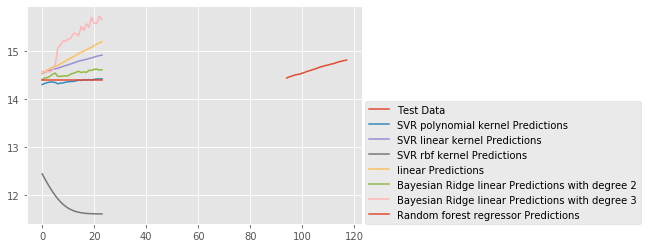

In [64]:
plt.plot(y_test)
plt.plot(svm_poly_test_pred)
plt.plot(svm_linear_test_pred)
plt.plot(svm_rbf_test_pred)
plt.plot(test_linear_pred)
plt.plot(test_bayesian_pred2)
plt.plot(test_bayesian_pred3)
plt.plot(test_rf_pred)
plt.legend(['Test Data','SVR polynomial kernel Predictions', 'SVR linear kernel Predictions', 'SVR rbf kernel Predictions', 
            'linear Predictions','Bayesian Ridge linear Predictions with degree 2',
            'Bayesian Ridge linear Predictions with degree 3','Random forest regressor Predictions'],loc=(1.01,0))


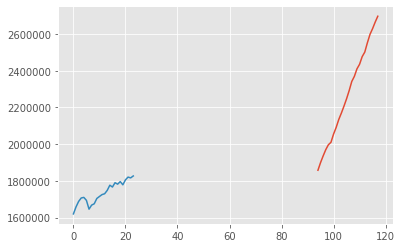

In [71]:
plt.plot(np.exp(y_test))
plt.plot(np.exp(svm_poly_test_pred))
#plt.plot(np.exp(svm_linear_test_pred))
#plt.plot(np.exp(svm_rbf_test_pred))
#plt.plot(np.exp(test_linear_pred))